In [ ]:
#Andrew Aquino
#Hello this is my implementation of using the DeepSort Algorithm on a video I took of my car with dents using 
#the trained Dinov3 Segmenation Head PyTorch weights 

In [2]:
!pip install deep_sort_realtime
!pip install torchmetrics
!pip install termcolor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 143.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.8 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/facebookresearch/dinov3.git

Cloning into 'dinov3'...
remote: Enumerating objects: 503, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 503 (delta 173), reused 103 (delta 93), pack-reused 213 (from 2)
Receiving objects: 100% (503/503), 9.87 MiB | 18.86 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [4]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict
import torch.nn.functional as F


In [ ]:
#this is how the model is loaded in to be rain again
repo = '/content/dinov3'
weights = '/content/drive/MyDrive/Assignment3/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth'
dino =  torch.hub.load(repo, 'dinov3_vitb16', source='local', weights=weights)

class SegmentationHead(nn.Module):
    #this is just a standard neural network bacbone
    def __init__(self, in_channels=768, num_classes=1):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        return self.decoder(x)


class DINOv3_Model(nn.Module):
    #here we use the dino_pretrained model and the neural network class defined above
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        #the dino method that extracts features from a layer, this case I chose the last one
        features = self.backbone.get_intermediate_layers(x, n=1)[0]
        # get the dino outputs batch size, number of token and channel dimenstions
        batch_size, number_tokens, channel_dimension = features.shape
        height = width = int(number_tokens ** 0.5) #height and widght of patch gird
        features = features.transpose(1, 2).reshape(batch_size, channel_dimension, height, width)
        mask = self.head(features) #the decorder network
        mask = F.interpolate(mask, size=x.shape[2:], mode='bilinear', align_corners=False)
        return mask



Downloading: "file:///content/drive/MyDrive/Assignment3/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


100%|██████████| 327M/327M [00:08<00:00, 41.9MB/s]


In [ ]:
# this function will load the model that I trained previously
def load_trained_model(checkpoint_path, device='cuda'):
    model = DINOv3_Model(dino, SegmentationHead()).to(device)

    # loads the Pytoch model with the weights and evaluates
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

#this transformation is the same as the training to process the frames in the video
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

def mask_to_bboxes(mask, confidence_threshold=0.5, min_area=100):

    #htis is used for convert the mask probabilty to a binary image
    mask_binary = (mask > confidence_threshold).astype(np.uint8) * 255

    # using OpenCVs method we can get data from each compents (like bounding boxe)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        mask_binary, connectivity=8
    )

    bboxes = []

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]

        # the  min area helps filter our unessary noise
        if area < min_area:
            continue

        # just gives how good the bounding box is
        component_mask = (labels == i)
        avg_confidence = mask[component_mask].mean()

        # just formatting the bounding boxes
        bbox = (x, y, x + w, y + h, float(avg_confidence))
        bboxes.append(bbox)

    return bboxes

def process_frame(frame, model, device='cuda', orig_size=None):

    # OpenCv likes to use BGR frame so this needs to be converteded to RBG
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)


    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    # the prediction portion which uses sigmoid for probabilty
    with torch.no_grad():
        output = model(input_tensor)
        mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # resizing the image back into the original
    if orig_size is not None:
        mask = cv2.resize(mask, (orig_size[1], orig_size[0]),
                         interpolation=cv2.INTER_LINEAR)

   # only take the bounding boxes with high confidence
    bboxes = mask_to_bboxes(mask, confidence_threshold=0.5, min_area=100)

    return mask, bboxes

#this will help draw the dents
def draw_dents(frame, tracks, mask=None, show_mask=True):

    annotated_frame = frame.copy()

    # I wanted is to visually show the segmenations on the dent
    # it should be like a semi-red almost transparent mask
    if show_mask and mask is not None:
        colored_mask = np.zeros_like(frame)
        colored_mask[:, :, 2] = (mask * 255).astype(np.uint8)

        annotated_frame = cv2.addWeighted(annotated_frame, 0.7, colored_mask, 0.3, 0)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()  # this is how to get the bounding boxes
        x1, y1, x2, y2 = map(int, ltrb)

        #get color for each bounding box and create them
        color = get_color_for_id(track_id) #this function is below
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
        label = f"Dent #{track_id}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)

        # The text that will be showing in the background of the video
        cv2.rectangle(annotated_frame, (x1, y1 - label_size[1] - 10), (x1 + label_size[0], y1), color, -1)
        cv2.putText(annotated_frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return annotated_frame

#this function just generates a random color for each unique ID
def get_color_for_id(track_id):
    np.random.seed(int(track_id))
    color = tuple(map(int, np.random.randint(0, 255, 3)))
    return color

#this is the main function that is needed for the video processing of the dents
def video_processing(video_path, model, output_path='output_dents.mp4', device='cuda'):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")

    # Just preprocessiung stuff to get the video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Processing video: {width}x{height} @ {fps}fps, {total_frames} frames")

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # This is the DeepSort Tracker
    tracker = DeepSort(
        max_age=30,          # Frames to keep track alive without detections
        n_init=3,            # Frames needed to confirm a track
        max_iou_distance=0.7, # IOU threshold for matching
        embedder="mobilenet", # Feature extractor for appearance
        half=True,           # Use FP16 for speed
        embedder_gpu=True    # Use GPU for embedder
    )

    unique_dent_ids = set()
    frame_count = 0
    print("Starting processing...")

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1

        # while the video is being process for each frame try to get detections
        mask, bboxes = process_frame(frame, model, device, orig_size=(height, width))

        # need to convert the bounding boxes to DeepSort Format
        detections = []
        for bbox in bboxes:
            x1, y1, x2, y2, confidence = bbox
            w = x2 - x1
            h = y2 - y1
            detections.append(([x1, y1, w, h], confidence, 'dent'))

        #this updates the tracked detections
        tracks = tracker.update_tracks(detections, frame=frame)
        for track in tracks:
            if track.is_confirmed():
                unique_dent_ids.add(track.track_id)

        annotated_frame = draw_dents(frame, tracks, mask, show_mask=True)

        # This is just added to count the number of dents the model thinks it detected
        dent_count = len(unique_dent_ids)
        count_text = f"Total Dents Detected: {dent_count}"
        cv2.putText(annotated_frame, count_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # frame counter
        frame_text = f"Frame: {frame_count}/{total_frames}"
        cv2.putText(annotated_frame, frame_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        out.write(annotated_frame)

        # update the current state of the process
        if frame_count % 30 == 0:
            print(f"Processed {frame_count}/{total_frames} frames, " f"Detected {dent_count} unique dents")

    cap.release()
    out.release()

    print(f"\nProcessing complete!")
    print(f"Total unique dents detected: {len(unique_dent_ids)}")
    print(f"Output saved to: {output_path}")

    return len(unique_dent_ids)


video_path = "/content/drive/MyDrive/Assignment3/20251102_102829.mp4"
model_pth = "/content/drive/MyDrive/Assignment3/best_segmentation_model.pth"
output_path = "/content/drive/MyDrive/Assignment3/output_tracked_dents_2.mp4"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

print("Loading trained model...")
model = load_trained_model(model_pth, device=device)

total_dents = video_processing(video_path, model, output_path, device=device)
print(f"\n✓ Done! Found {total_dents} unique dents in the video.")

Using device: cuda
Loading trained model...
Processing video: 1080x1920 @ 29fps, 2085 frames
Starting processing...
Processed 30/2085 frames, Detected 4 unique dents
Processed 60/2085 frames, Detected 8 unique dents
Processed 90/2085 frames, Detected 11 unique dents
Processed 120/2085 frames, Detected 20 unique dents
Processed 150/2085 frames, Detected 25 unique dents
Processed 180/2085 frames, Detected 29 unique dents
Processed 210/2085 frames, Detected 32 unique dents
Processed 240/2085 frames, Detected 40 unique dents
Processed 270/2085 frames, Detected 41 unique dents
Processed 300/2085 frames, Detected 42 unique dents
Processed 330/2085 frames, Detected 42 unique dents
Processed 360/2085 frames, Detected 43 unique dents
Processed 390/2085 frames, Detected 46 unique dents
Processed 420/2085 frames, Detected 46 unique dents
Processed 450/2085 frames, Detected 47 unique dents
Processed 480/2085 frames, Detected 50 unique dents
Processed 510/2085 frames, Detected 51 unique dents
Proce

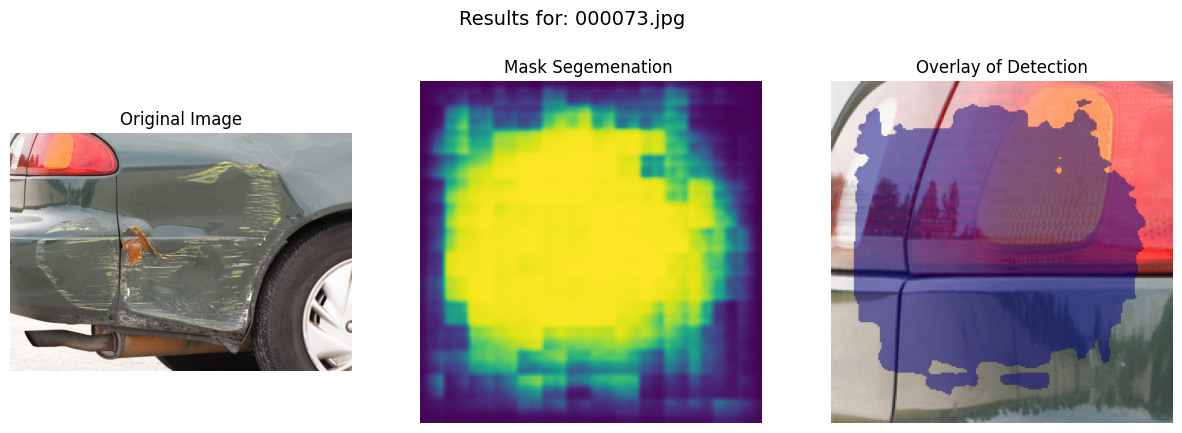

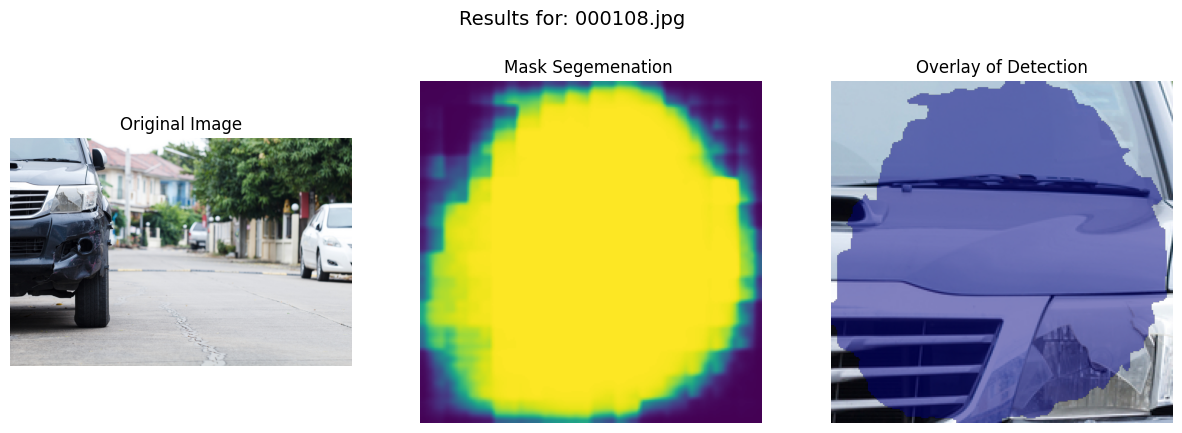

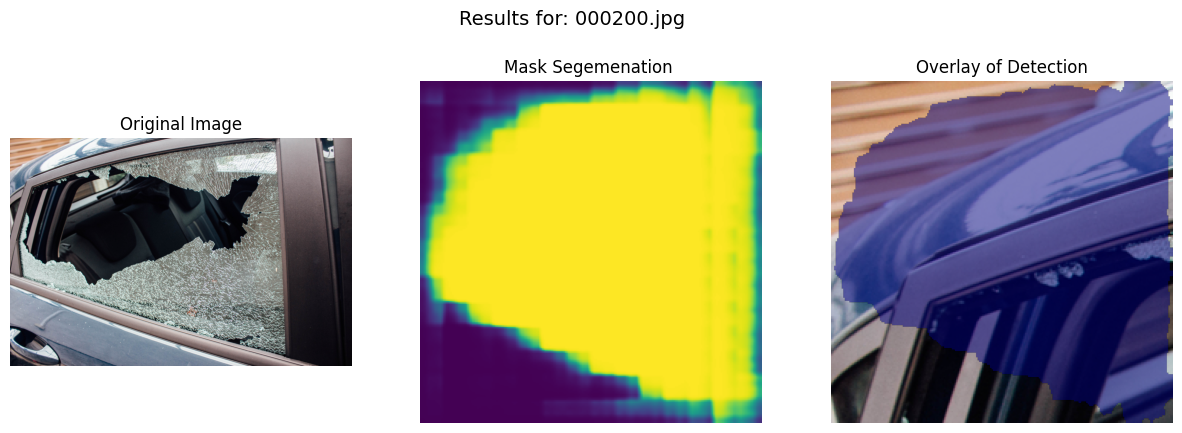

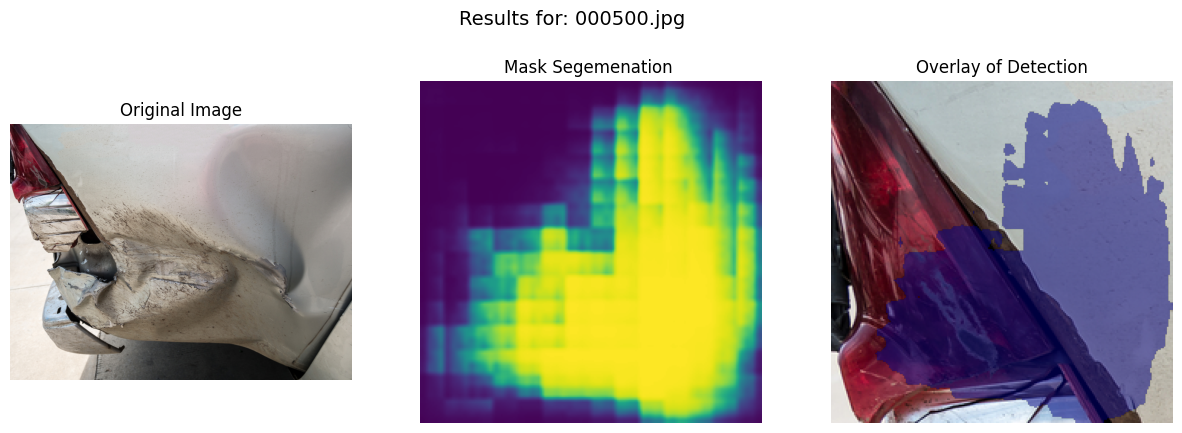

In [17]:
import matplotlib.pyplot as plt

#the to load the trained model
def load_trained_model(checkpoint_path, device='cuda'):
    model = DINOv3Segmentation(dino, SegmentationHead()).to(device)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

# the images I want show
img_paths = ['/content/drive/MyDrive/Assignment3/CarDD/data/000073.jpg',
             '/content/drive/MyDrive/Assignment3/CarDD/data/000108.jpg',
             '/content/drive/MyDrive/Assignment3/CarDD/data/000200.jpg',
             '/content/drive/MyDrive/Assignment3/CarDD/data/000500.jpg',]
# img = Image.open(img_path).convert("RGB")
# input_tensor = transform(img).unsqueeze(0)

# Predict mask
MODEL_CHECKPOINT = "/content/drive/MyDrive/Assignment3/best_segmentation_model.pth"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_trained_model(MODEL_CHECKPOINT, device=DEVICE)

# # Move input tensor to the correct device
# input_tensor = input_tensor.to(DEVICE)

# with torch.no_grad():
#     output = model(input_tensor)
#     pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # [H, W]

#this  function will load the images then predict the mask and show the results
def visualize_prediction(img_path, model, device, transform):
    """Loads an image, predicts the mask, and visualizes the results."""

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        output = model(input_tensor)

        pred_mask_probs = torch.sigmoid(output).squeeze().cpu().numpy()


    binary_mask = (pred_mask_probs > 0.5).astype(float)

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Results for: {img_path.split('/')[-1]}", fontsize=14)


    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_probs, cmap='viridis')
    plt.title("Mask Segemenation ")
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(img)
    masked_img = np.ma.masked_where(binary_mask == 0, binary_mask)
    plt.imshow(masked_img, cmap='jet', alpha=0.5)
    plt.title("Overlay of Detection")
    plt.axis('off')

    plt.show()


for path in img_paths:
    visualize_prediction(path, model, DEVICE, transform)